In [1]:
import sys
sys.path.insert(0, '../')
from gw_tools.gw_plot import gw_plot
from gw_tools import data_prep
from gw_tools.gw_cnn import gw_cnn

import IPython
import IPython.display
import keras
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import Input
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.losses import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
## Load cleaned data
df = data_prep.load_data('AEK201')
## Select features for training
df = data_prep.select_features(df)
## Add time of year signal information
df = data_prep.add_toy_signal(df)
## Set aside holdout data for final model validation
X_train, X_holdout, y_train, y_holdout, dt_train, dt_holdout = data_prep.prep_data_for_training(df)

In [3]:
## Determine the hyper-parameters and make the model

## Make the model
gw_cnn = gw_cnn(C1_LAYER=True, C1_FILTERS=32, C1_KERNEL=16,
                    C2_LAYER=True, C2_FILTERS=128, C2_KERNEL=24,
                    C3_LAYER=True, C3_FILTERS=64, C3_KERNEL=36,
                    D_MAX_LAYERS = 8, D_TOP_UNITS = 150, D_MIN_UNITS=3,
                    D_UNIT_SCALE = 0.1,
                    LEARNING_RATE=0.001,
                    EPOCHS=100, BATCH_SIZE=32, STOP_DELTA=.1,
                    RANDOM_STATE = 90210)


# Cross validation splits
N_SPLITS = 3

## For splitting the data
tscv = TimeSeriesSplit(n_splits=N_SPLITS, test_size=365, gap=0)

## For scaling the data
scaler =  StandardScaler(copy=True)

## Set up the pipeline
pipe = Pipeline([('scaler', scaler), ('model', gw_cnn)])

In [4]:
## Cross validate
mses_cnn = np.zeros(N_SPLITS)

i = 0
for train, test in tscv.split(X_train, y_train):
    ## Split the data into train/test sets
    X_tt = X_train[train]
    y_tt = y_train[train]
    X_ho = X_train[test]
    y_ho = y_train[test]

    ## Fit the model
    pipe.fit(X_tt,y_tt)

    ## Make predictions
    pred = pipe.predict(X_ho)

    ## Score the model
    mse = np.mean((y_ho - pred)**2)
    mses_cnn[i] = mse

    i += 1

Epoch 1/100


2023-11-15 16:10:43.309224: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-15 16:10:43.309244: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-11-15 16:10:43.309249: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-11-15 16:10:43.309298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-15 16:10:43.309313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 1/90 [..............................] - ETA: 28s - loss: 4529.6768

2023-11-15 16:10:43.633390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - 1s 6ms/step - loss: 663.8423
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 97.6320
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 23.9676
Epoch 4/100
90/90 [==============================] - 0s 5ms/step - loss: 8.8529
Epoch 5/100
90/90 [==============================] - 0s 5ms/step - loss: 4.7696
Epoch 6/100
90/90 [==============================] - 0s 5ms/step - loss: 2.1850
Epoch 7/100
90/90 [==============================] - 0s 5ms/step - loss: 1.6028
Epoch 8/100
90/90 [==============================] - 0s 5ms/step - loss: 1.2632
Epoch 9/100
90/90 [==============================] - 0s 5ms/step - loss: 1.0908
Epoch 10/100
90/90 [==============================] - 0s 5ms/step - loss: 1.0217
Epoch 11/100
90/90 [==============================] - 0s 5ms/step - loss: 1.0295
Epoch 12/100
90/90 [==============================] - 0s 5ms/step - loss: 0.6498
Epoch 13/100
90/90 [=========================

2023-11-15 16:10:50.958883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 11/101 [==>...........................] - ETA: 0s - loss: 2925.9338 

2023-11-15 16:10:51.203264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


101/101 [==============================] - 1s 5ms/step - loss: 561.5487
Epoch 2/100
101/101 [==============================] - 0s 5ms/step - loss: 57.0704
Epoch 3/100
101/101 [==============================] - 0s 5ms/step - loss: 10.7574
Epoch 4/100
101/101 [==============================] - 0s 5ms/step - loss: 3.6739
Epoch 5/100
101/101 [==============================] - 0s 5ms/step - loss: 1.9737
Epoch 6/100
101/101 [==============================] - 0s 5ms/step - loss: 1.2635
Epoch 7/100
101/101 [==============================] - 0s 5ms/step - loss: 1.2903
Epoch 8/100
101/101 [==============================] - 0s 5ms/step - loss: 1.0108
Epoch 9/100
101/101 [==============================] - 0s 5ms/step - loss: 1.0084
Epoch 10/100
101/101 [==============================] - 0s 5ms/step - loss: 0.9175
Epoch 11/100
101/101 [==============================] - 0s 5ms/step - loss: 0.8317
Epoch 12/100
101/101 [==============================] - 0s 5ms/step - loss: 0.7004
Epoch 13/100
101/101 

2023-11-15 16:10:59.145157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 10/112 [=>............................] - ETA: 0s - loss: 2664.1494 

2023-11-15 16:10:59.370816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - 1s 5ms/step - loss: 423.1931
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 25.2507
Epoch 3/100
112/112 [==============================] - 1s 5ms/step - loss: 5.5837
Epoch 4/100
112/112 [==============================] - 1s 5ms/step - loss: 2.3749
Epoch 5/100
112/112 [==============================] - 1s 5ms/step - loss: 1.9016
Epoch 6/100
112/112 [==============================] - 1s 5ms/step - loss: 1.4818
Epoch 7/100
112/112 [==============================] - 1s 5ms/step - loss: 1.1148
Epoch 8/100
112/112 [==============================] - 1s 5ms/step - loss: 0.8876
Epoch 9/100
112/112 [==============================] - 1s 5ms/step - loss: 0.9762
Epoch 10/100
112/112 [==============================] - 1s 5ms/step - loss: 0.8878
Epoch 11/100
112/112 [==============================] - 1s 5ms/step - loss: 0.6753
Epoch 12/100
112/112 [==============================] - 1s 5ms/step - loss: 0.7535
Epoch 13/100
112/112 [

2023-11-15 16:11:07.512263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [5]:
mses_cnn

array([22.06865309, 14.53669838, 17.75754718])

12/12 [==============================] - 0s 2ms/step
The last model in trained had a mean square error of 17.757547182992806


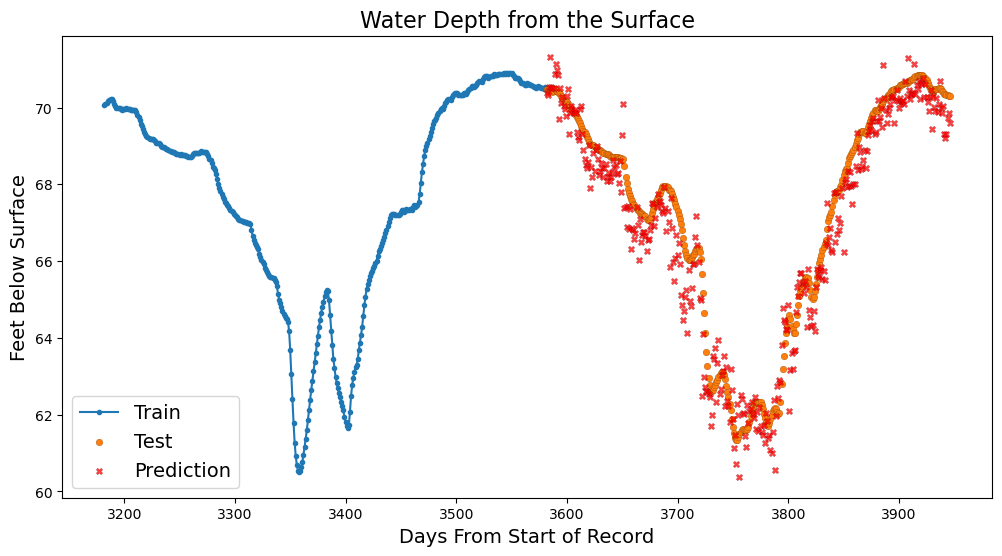

In [6]:
## Score the last model and output the result
pred = pipe.predict(X_ho)
score = np.mean((y_ho-pred)**2)
print(f'The last model in trained had a mean square error of {score}')
gw_plot(train = y_tt, test = y_ho, pred = pred, train_limit=400)

Epoch 1/100
  9/124 [=>............................] - ETA: 0s - loss: 4072.5769 

2023-11-15 16:11:07.938287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - 1s 6ms/step - loss: 566.8539
Epoch 2/100
124/124 [==============================] - 1s 5ms/step - loss: 30.2193
Epoch 3/100
124/124 [==============================] - 1s 5ms/step - loss: 4.7535
Epoch 4/100
124/124 [==============================] - 1s 5ms/step - loss: 2.2801
Epoch 5/100
124/124 [==============================] - 1s 5ms/step - loss: 1.6807
Epoch 6/100
124/124 [==============================] - 1s 5ms/step - loss: 1.0265
Epoch 7/100
124/124 [==============================] - 1s 5ms/step - loss: 0.9273
Epoch 8/100
124/124 [==============================] - 1s 5ms/step - loss: 0.7884
Epoch 9/100
124/124 [==============================] - 1s 5ms/step - loss: 0.6682
Epoch 10/100
124/124 [==============================] - 1s 5ms/step - loss: 0.6791
Epoch 11/100
124/124 [==============================] - 1s 5ms/step - loss: 0.5965
Epoch 12/100
124/124 [==============================] - 1s 5ms/step - loss: 0.6625
Epoch 13/100
12/12 [==

2023-11-15 16:11:16.023234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


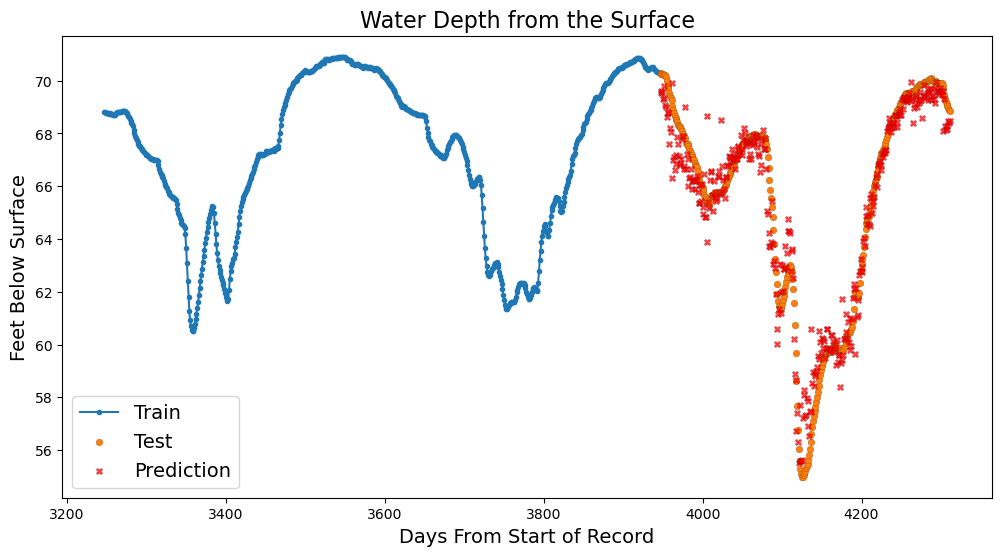

In [7]:
## Training on the whole data set   
pipe.fit(X_train,y_train)

## Making a prediction on the holdout set
pred = pipe.predict(X_holdout)

score = np.sqrt(np.mean((y_holdout - pred)**2))

print(f'This model has a root mean square error of {np.sqrt(score)} when evaluated on the holdout data')

gw_plot(train = y_train, test = y_holdout, pred = pred,train_limit=700)